**Install Dependencies**

In [ ]:
# %%capture
# !pip install -U torch torchvision torchaudio torcheval
# !pip install -U triton xformers
# !pip install -U diffusers transformers accelerate jupyter huggingface-hub bitsandbytes tqdm;
# !pip install -U cjm_pil_utils cjm_pytorch_utils cjm_kaggle_utils cjm_pandas_utils

**Check diffusers version**

In [ ]:
import diffusers
diffusers.__version__

'0.12.1'

In [ ]:
from pathlib import Path
import hashlib
import json
import itertools
import multiprocessing
import math
import os
import random

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset

from PIL import Image
import numpy as np

import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, StableDiffusionDepth2ImgPipeline, UNet2DConditionModel
from diffusers import PNDMScheduler
from diffusers.optimization import get_scheduler

from tqdm.auto import tqdm

In [ ]:
# Import utility functions
from cjm_pil_utils.core import get_img_files, stack_imgs
from cjm_pytorch_utils.core import get_torch_device

**Set device and data type**

In [ ]:
device = get_torch_device()
dtype = torch.float16 if device == device else torch.float32
device, dtype

('cuda', torch.float16)

**Log into Hugging Face Hub**

1. Generate a user access token: [Access Tokens](https://huggingface.co/settings/tokens)
2. Paste your token when prompted after running the code cell below.

In [ ]:
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

**Accept Model License**

The Stable Diffusion checkpoints are available under the [CreativeML Open RAIL++-M License](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL). The license claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. Open the Model Card pages below and accept the license agreement to download the pretrained models.. 


If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work.

* [**Stable Diffusion v2 Depth Model Card**](https://huggingface.co/stabilityai/stable-diffusion-2-depth)

**Select a model**

In [ ]:
model_name = "stabilityai/stable-diffusion-2-depth"

**Load autoencoder**

In [ ]:
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(device=device, dtype=dtype)

**Load unet**

In [ ]:
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(device=device)

In [ ]:
# Try to use xFormers for memory efficient attention
try:
    unet.enable_xformers_memory_efficient_attention()
except:
    print("Unable to use xformers.")

**Load tokenizer**

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")

**Load text encoder**

In [ ]:
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(device)

**Define training noise scheduler**

In [ ]:
train_scheduler = PNDMScheduler.from_pretrained(model_name, subfolder="scheduler")

**Freeze parameters for models not being trained**

In [ ]:
# Whether to train the text encoder
train_text_encoder = True

# Freeze the gradients of the VAE model
vae.requires_grad_(False)

# Freeze the gradients of the text encoder if not training it
if not train_text_encoder:
    text_encoder.requires_grad_(False)

**Enable gradient checkpointing**

In [ ]:
# Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.
gradient_checkpointing = False

# Enable gradient checkpointing for the U-Net model
if gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    # Enable gradient checkpointing for the text encoder if it is being trained
    if train_text_encoder:
        text_encoder.gradient_checkpointing_enable()

**Set path to image dataset**

In [ ]:
dataset_path = Path('./train_dir/cp2077-steelbook-custom-768/')

**Set path to image folder**

In [ ]:
# Set the path for the images directory
img_dir = Path(dataset_path/"images/")
img_dir

PosixPath('train_dir/cp2077-steelbook-custom-768/images')

**Get image paths**

In [ ]:
# Get a list of the paths to the images in the images directory
img_paths = list(get_img_files(img_dir))

# Print the number of images in the images directory
print(f"Images: {len(img_paths)}")

Images: 46


**Map image IDs to file paths**

In [ ]:
# Create a dictionary mapping image IDs to image paths
img_path_dict = {path.stem.split('-')[-1] : path for path in img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(img_path_dict, orient='index').head()

,0
618fc3a1,train_dir/cp2077-steelbook-custom-768/images/tyger_claws_b1-618fc3a1.png
867056cc,train_dir/cp2077-steelbook-custom-768/images/valentinos_b1-867056cc.png
20847e24,train_dir/cp2077-steelbook-custom-768/images/maelstrom_b1-20847e24.png
261ab67f,train_dir/cp2077-steelbook-custom-768/images/maelstrom_b1-261ab67f.png
41616c28,train_dir/cp2077-steelbook-custom-768/images/maelstrom_b1-41616c28.png


**Set path to prompt DataFrame**

In [ ]:
# Set the file path for the prompts dataframe
prompts_df_json_file = Path(dataset_path/'prompts_df.json')

# Print the file path
print(prompts_df_json_file)

train_dir/cp2077-steelbook-custom-768/prompts_df.json


**Load image prompts**

In [ ]:
# Read the prompts dataframe from the JSON file
prompts_df = pd.read_json(prompts_df_json_file)

# Print the number of entries in the dataframe
print(f"Number of entries: {len(prompts_df)}")

# Display the first few rows of the dataframe
prompts_df.head()

Number of entries: 46


,prompt
0a07b120,A metal rooftop sign with an arrow above the letters B O D E G A on top of a building. A man's forehead is visible at the bottom of the image.
0cfbedaa,A man wearing an eye visor kneeling on one knee while plugging a tube into the side of a chair with another man sitting on it.
1276c1a1,A low-angle view of digital cafe sign on the side of a building with graffiti on it.
20847e24,A guy wearing goggles and a tactical vest holding an inhaler in his left hand while lounging on a red couch with a sword sticking out of it.
21436daa,A short table with some candles and a skull on top of it behind a couch.


**Set path to depth dataset**

In [ ]:
depth_dataset_path = Path('./train_dir/cp2077-steelbook-custom-768-depth/')

**Set path to depth images folder**

In [ ]:
# Set the path for the images directory
depth_img_dir = Path(depth_dataset_path/"images/")
depth_img_dir

PosixPath('train_dir/cp2077-steelbook-custom-768-depth/images')

**Get depth image paths**

In [ ]:
# Get a list of the paths to the images in the images directory
depth_img_paths = list(get_img_files(depth_img_dir))

# Print the number of images in the images directory
print(f"Images: {len(depth_img_paths)}")

Images: 47


**Map image IDs to file paths**

In [ ]:
# Create a dictionary mapping image IDs to image paths
depth_img_path_dict = {path.stem.split('-')[-1] : path for path in depth_img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(depth_img_path_dict, orient='index').head()

,0
3aca8c35,train_dir/cp2077-steelbook-custom-768-depth/images/depth-tyger_claws_b1-3aca8c35.png
54d065a7,train_dir/cp2077-steelbook-custom-768-depth/images/depth-valentinos_b1-54d065a7.png
20847e24,train_dir/cp2077-steelbook-custom-768-depth/images/depth-maelstrom_b1-20847e24.png
261ab67f,train_dir/cp2077-steelbook-custom-768-depth/images/depth-maelstrom_b1-261ab67f.png
41616c28,train_dir/cp2077-steelbook-custom-768-depth/images/depth-maelstrom_b1-41616c28.png


**Store list of image IDs**

In [ ]:
img_ids = list(img_path_dict.keys())

**Display sample image**

ID: e3ed4a51
Prompt: A close-up of the front of a motorcycle with stickers on it.


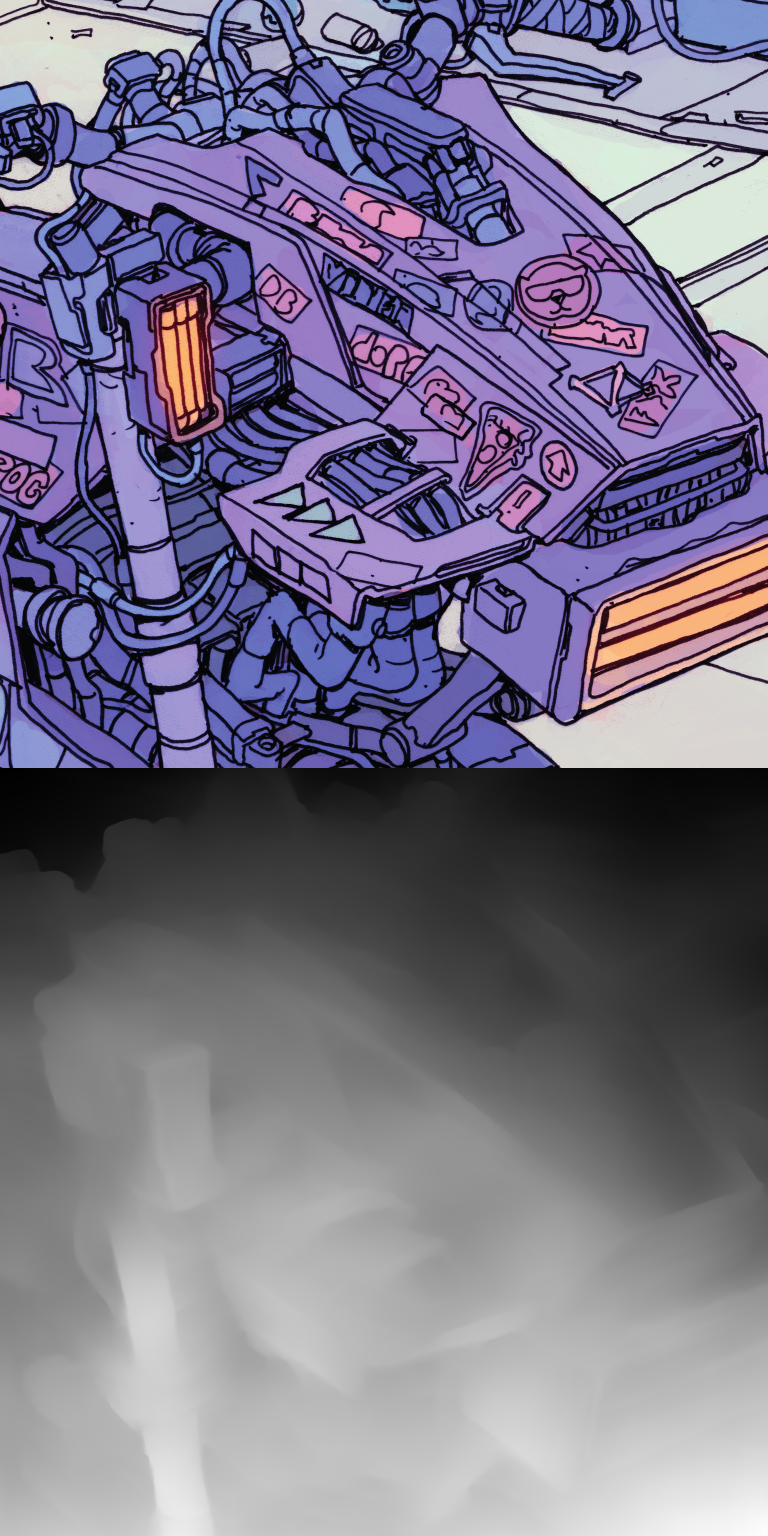

In [ ]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids)

print(f"ID: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
img_path = img_path_dict[img_id]
sample_img = Image.open(img_path)

# Print the title of the image, located in the 'prompt' column of the prompts_df dataframe
print(f"Prompt: {prompts_df.loc[img_id]['prompt']}")

depth_map = Image.open(depth_img_path_dict[img_id])    

# Display the image and its depth map
stack_imgs([sample_img, depth_map])

**Define dreambooth dataset class**

In [ ]:
class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        img_ids,
        img_path_dict,
        prompt_dict,
        depth_img_path_dict,
        tokenizer,
        size=512,
    ):
        
        self.img_ids = img_ids
        self.img_path_dict = img_path_dict
        self.num_instance_images = len(self.img_ids)
        self.prompt_dict = prompt_dict
        self.depth_img_path_dict = depth_img_path_dict
        
        self.size = size
        self.tokenizer = tokenizer

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        
        self.depth_image_transforms = transforms.Compose(
            [
                transforms.Resize(size // 8, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ]
        )

    def __len__(self):
        return self.num_instance_images

    def __getitem__(self, index):
        example = {}
        img_id = self.img_ids[index % self.num_instance_images]
        
        img_path = self.img_path_dict[img_id]
        instance_image = Image.open(img_path).convert("RGB")
        example["pixel_values"] = self.image_transforms(instance_image)
        
        depth_img_path = self.depth_img_path_dict[img_id]
        instance_depth_image = Image.open(depth_img_path).convert("L")
        example["depth_values"] = self.depth_image_transforms(instance_depth_image)
        
        prompt = self.prompt_dict[img_id]
        example["input_ids"] = self.tokenizer(
            prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        
        return example

**Define training prompt**

In [ ]:
new_token = "<cp2077-steelbook>"

**Add new token to tokenizer**

In [ ]:
if tokenizer.add_tokens(new_token) == 0: 
    print("Token already present.")
else:
    # Encode new token
    new_token_id = tokenizer.convert_tokens_to_ids(new_token)
    # Resize text encoder
    text_encoder.resize_token_embeddings(len(tokenizer))

**Construct training prompts**

In [ ]:
# Define a function that constructs the prompts using the 'title' and 'tags' columns
def construct_prompt(row):
    return f"{new_token} style, {row['prompt']}"

# Apply the 'construct_prompt' function to each row of the DataFrame
# and store the result in a dictionary with keys as image IDs
prompt_dict = prompts_df.apply(construct_prompt, axis=1).to_dict()

**Print a sample training prompt**

In [ ]:
prompt_dict[img_id]

'<cp2077-steelbook> style, A close-up of the front of a motorcycle with stickers on it.'

**Define training variables**

In [ ]:
bs = 1

**Initialize training dataset**

In [ ]:
train_dataset = DreamBoothDataset(
    img_ids=img_ids,
    img_path_dict=img_path_dict,
    prompt_dict=prompt_dict,
    depth_img_path_dict=depth_img_path_dict,
    tokenizer=tokenizer,
    size=768,
)

**Define custom collate function for training dataloader**

In [ ]:
def collate_fn(examples):
    input_ids = [example["input_ids"] for example in examples]
    pixel_values = [example["pixel_values"] for example in examples]
    depth_values = [example["depth_values"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format)
    
    depth_values = torch.stack(depth_values)
    depth_values = depth_values.to(memory_format=torch.contiguous_format)

    input_ids = tokenizer.pad(
        {"input_ids": input_ids},
        padding="max_length",
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
        "depth_values": depth_values
    }
    return batch

**Initialize dataloader**

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=bs, 
                                               shuffle=True, 
                                               collate_fn=collate_fn, 
                                               num_workers=multiprocessing.cpu_count(), 
                                               pin_memory=True)

**Define training variables**

In [ ]:
# Total number of training epochs
epochs = 100
# Total number of training steps to perform.  If provided, overrides epochs.
max_train_steps = len(img_paths) * epochs
# Number of updates steps to accumulate before performing a backward/update pass.
gradient_accumulation_steps = 1

**Define learning rate variables**

In [ ]:
# Initial learning rate (after the potential warmup period) to use.
learning_rate = 1e-6
# Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.
scale_lr = True
# The scheduler type to use. 
# Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"]
lr_scheduler = "constant"
# Number of steps for the warmup in the lr scheduler.
# lr_warmup_steps = max_train_steps / 10
lr_warmup_steps = 0

**Scale learning rate**

In [ ]:
if scale_lr: learning_rate = learning_rate * gradient_accumulation_steps * bs

**Define which model parameters to optimize**

In [ ]:
params_to_optimize = (
    itertools.chain(unet.parameters(), text_encoder.parameters()) if train_text_encoder else unet.parameters()
)

**Initialize optimizer**

In [ ]:
# Use 8-bit Adam for lower memory usage when available
# https://github.com/TimDettmers/bitsandbytes
try:
    import bitsandbytes as bnb
    optimizer_class = bnb.optim.AdamW8bit
except ImportError:
    optimizer_class = torch.optim.AdamW
print(f"Optimizer Class: {optimizer_class.__name__}")

optimizer = optimizer_class(params_to_optimize, lr=learning_rate)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
Optimizer Class: AdamW8bit


**Define learning rate scheduler**

In [ ]:
lr_scheduler = get_scheduler(
    lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps * gradient_accumulation_steps,
    num_training_steps=max_train_steps * gradient_accumulation_steps,
)

**Finetune model**

In [ ]:
total_batch_size = bs * gradient_accumulation_steps

text_encoder = text_encoder.float()
unet = unet.float()

# Initialize gradient scaler
scaler = torch.cuda.amp.GradScaler()

for epoch in tqdm(range(epochs)):
    unet.train()
    if train_text_encoder: text_encoder.train()
    
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(len(train_dataloader)))
    progress_bar.set_description("Steps")
    
    # Initialize the aggregate loss
    agg_loss = 0
        
    for step, batch in enumerate(train_dataloader):
        # Convert images to latent space
        latents = vae.encode(batch["pixel_values"].to(device=device, dtype=dtype)).latent_dist.sample()
        latents = latents * 0.18215

        # Sample noise that we'll add to the latents
        noise = torch.randn(latents.shape, device=device, dtype=latents.dtype)
        
        bsz = latents.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, train_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()
        
        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_latents = train_scheduler.add_noise(latents, noise, timesteps)
        
        noisy_latents = torch.cat([noisy_latents, batch["depth_values"].type_as(noisy_latents)], dim=1)

        # Get the text embedding for conditioning
        encoder_hidden_states = text_encoder(batch["input_ids"].to(device=device))[0]
        
        # Run forward pass under autocast
        with torch.cuda.amp.autocast():
            
            # Predict the noise residual
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            
            if train_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif train_scheduler.config.prediction_type == "v_prediction":
                target = train_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {train_scheduler.config.prediction_type}")
            
            loss = F.mse_loss(model_pred, target, reduction="mean")
                
            # Scale loss value based on number of accumulation steps
            loss = loss / gradient_accumulation_steps
            
        # Scale loss
        scaler.scale(loss).backward()
        
        # Get gradients for token embeddings
        grads = text_encoder.get_input_embeddings().weight.grad
        # Get indices for embeddings that should not change
        index_grads_to_zero = torch.arange(len(tokenizer)) != new_token_id
        # Zero gradients for zero gradients for embeddings that should not change
        grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)
        
        # Gradient accumulation
        if (step + 1) % gradient_accumulation_steps == 0:
            
            # Unscale gradients
            scaler.step(optimizer)
            # Update scale
            scaler.update()
            # Reset gradients
            optimizer.zero_grad(set_to_none=True)
            
            lr_scheduler.step()
        
        # Update progress bar
        progress_bar.update(1)
        # Add the loss to the aggregate loss
        agg_loss += loss.detach().item()
        # Create a dictionary of logs to display in the progress bar
        logs = {"loss": loss.detach().item(), 
                "avg_loss": agg_loss/(step+1),
                "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        
# Releases all unoccupied cached memory
torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

**Define save path for finetuned models**

In [ ]:
dreambooth_dir = Path("./dreambooth_checkpoints")
dreambooth_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = Path(dreambooth_dir/f"{new_token[1:-1]}-768-depth")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir

PosixPath('dreambooth_checkpoints/cp2077-steelbook-768-depth')

**Prepare unet and text encoder for inference**

In [ ]:
# Set the U-Net and text encoder models to half-precision floating point
unet.to(dtype=dtype);
text_encoder.to(dtype=dtype);

# Set the U-Net and text encoder models to evaluation mode
unet.eval();
text_encoder.eval();

**Save finetuned models**

In [ ]:
unet.config['_name_or_path'] = str(unet.config['_name_or_path'])
unet.config['_name_or_path']

'stabilityai/stable-diffusion-2-depth'

In [ ]:
vae.config['_name_or_path'] = str(vae.config['_name_or_path'])
vae.config['_name_or_path']

'stabilityai/stable-diffusion-2-depth'

In [ ]:
# Create the pipeline using using the trained modules and save it.
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    unet=unet,
#     tokenizer=tokenizer,
    text_encoder=text_encoder,
    torch_dtype=dtype
).to(device)

pipe.save_pretrained(checkpoint_dir)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
added_tokens_path = Path(checkpoint_dir/"tokenizer/added_tokens.json")

In [ ]:
import json
# Open a file for writing
with open(added_tokens_path, "w") as outfile:
    # Write the dictionary to the file
    json.dump(tokenizer.added_tokens_encoder, outfile)